<div style="width: 30%; float: right; margin: 10px; margin-right: 5%;">
    <img src="https://upload.wikimedia.org/wikipedia/commons/thumb/d/d3/FHNW_Logo.svg/2560px-FHNW_Logo.svg.png" width="500" style="float: left; filter: invert(50%);"/>
</div>

<h1 style="text-align: left; margin-top: 10px; float: left; width: 60%;">
    npr Mini-Challenge 1: <br>CNN
</h1>

<p style="clear: both; text-align: left;">
    Bearbeitet durch Florin Barbisch, Gabriel Torres Gamez und Jan Zwicky im HS 2023.
</p>

## Modellerklärung

CNN spielen eine zentrale Rolle in vielen Deep Learning Architekturen. Zuerst dachten wir, dass im Bereich von Deep Learning mit Textdaten die Transformerarchitekturen CNN's komplett ersetzt haben, doch unser Fachexperte meinte, dass sie immer noch eine Rolle spielen. Um dies zu untersuchen, suchten wir zuerst nach aktuellen Publikationen in diesem Bereich. Wir fanden dabei diverse Publikationen (https://link.springer.com/article/10.1007/s11042-022-13459-x, https://link.springer.com/article/10.1007/s10489-022-04221-9). In diesem Abschnitt möchte wir untersuchen, ob es möglich ist CNN zu verwenden, um eine gute Performance in einem NLP-Klassifikationstask zu erreichen. Eine "gute" Performance wird erreicht, sobald ein höherer F1-Score wie das Baseline erreicht wird.

## Requirements, Imports und Einstellungen
Hier werden die benötigten Python-Pakete importiert und die Einstellungen für die Plots
vorgenommen. 

In [179]:
# All Imports
import sys
import torch
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
import seaborn as sns
import sklearn
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
import gensim
import gensim.downloader as api
from   tensorflow import keras
from tensorflow.keras.preprocessing.text import text_to_word_sequence
# https://machinelearningmastery.com/prepare-text-data-deep-learning-keras/
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
import keras.backend as K

# Versions of the packages used
print(f"Python Version: {sys.version}")
print(f"PyTorch Version: {torch.__version__}")
print(f"Numpy Version: {np.__version__}")
print(f"Pandas Version: {pd.__version__}")
print(f"Matplotlib Version: {plt.matplotlib.__version__}")
print(f"Sklearn Version: {sklearn.__version__}")
print(f"Seaborn Version: {sns.__version__}")
print(f"Tensorflow Version: {tf.__version__}")
print(f"Gensim Version: {gensim.__version__}")

# Warnings Settings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Numpy Settings
np.set_printoptions(precision=2, suppress=True)
np.random.seed(42)

# Matplotlib Settings
plt.rcParams["figure.figsize"] = (24, 12)

Python Version: 3.10.7 (tags/v3.10.7:6cc6b13, Sep  5 2022, 14:08:36) [MSC v.1933 64 bit (AMD64)]
PyTorch Version: 1.12.1+cu116
Numpy Version: 1.23.5
Pandas Version: 1.5.0
Matplotlib Version: 3.6.2
Sklearn Version: 1.1.2
Seaborn Version: 0.12.0
Tensorflow Version: 2.11.0
Gensim Version: 4.3.2


## Einlesen des Verarbeiteten Datensatzes

In [120]:
train = pd.read_csv("./data/processed/train.csv",index_col="id")
val = pd.read_csv("./data/processed/val.csv",index_col="id")
test = pd.read_csv("./data/raw/test.csv",index_col="id")

## Pre-Processing

### Tokens for all embeddings

In [121]:
tokenizer = Tokenizer(num_words=20000)
tokenizer.fit_on_texts(train.text)

train_tokens = tokenizer.texts_to_sequences(train.text)
val_tokens = tokenizer.texts_to_sequences(val.text)

vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index

categories = 1 

print(f"Maximal number of words of sentences {max([len(lst) for lst in train_tokens])}")

maxlen = 40

train_tokens = pad_sequences(train_tokens, padding='post', maxlen=maxlen)
val_tokens = pad_sequences(val_tokens, padding='post', maxlen=maxlen)

Maximal number of words of sentences 31


### Word2Vec embeddings

In [246]:
def get_weight_matrix(embedding, vocab):
    # total vocabulary size plus 0 for unknown words
    vocab_size = len(vocab) + 1
    # define weight matrix dimensions with all 0
    weight_matrix = np.zeros((vocab_size, 300))
    # step vocab, store vectors using the Tokenizer's integer mapping
    unrecognized_words = 0
    for word, i in vocab.items():
        try:
            weight_matrix[i] = embedding[word]
        except:
            weight_matrix[i] = np.zeros(300)
            unrecognized_words += 1
    
    print(f"{unrecognized_words} words are not recognized")
    return weight_matrix


# get vectors in the right order
word2vec_google_news = api.load("word2vec-google-news-300")
embedding_vectors = get_weight_matrix(word2vec_google_news, tokenizer.word_index)
embedding_word2vec = keras.layers.Embedding(vocab_size, 300, weights=[embedding_vectors], input_length=40, trainable=True)

9587 words are not recognized


### Bert tweet embeddings

In [140]:
def get_weight_bert(embedding, vocab,tokenizer_bert):
    # total vocabulary size plus 0 for unknown words
    vocab_size = len(vocab) + 1
    # define weight matrix dimensions with all 0
    weight_matrix = np.zeros((vocab_size, 768))
    # step vocab, store vectors using the Tokenizer's integer mapping
    unrecognized_words = 0
    for word, i in vocab.items():
        try:
            weight_matrix[i] = embedding[tokenizer_bert[word]]
        except:
            weight_matrix[i] = np.zeros(768)
            unrecognized_words += 1
    print(f"{unrecognized_words} words are not recognized")
    return weight_matrix

In [152]:
from transformers import AutoModel, AutoTokenizer
bertweet = AutoModel.from_pretrained("vinai/bertweet-base")
tokenizer_bertweet = AutoTokenizer.from_pretrained("vinai/bertweet-base")
embedding_bert_matrix = bertweet.embeddings.word_embeddings.weight


embedding_bert = get_weight_bert(embedding_bert_matrix.detach().numpy(), tokenizer.word_index,tokenizer_bertweet.get_vocab())
embedding_bert = keras.layers.Embedding(vocab_size, 768, weights=[embedding_bert], input_length=40, trainable=True)

11501 words are not recognized


## Helper Functions

Hier werden Funktionen definiert, die bei beiden Modellen verwendet werden.

In [221]:
def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val


def plot_confusion_matrix(model,val_tokens=val_tokens):
    y_prediction = model.predict(val_tokens,verbose=False) > 0.5
    disp= ConfusionMatrixDisplay(confusion_matrix(val.target, y_prediction),display_labels = ["no disaster","disaster"])
    fig, ax = plt.subplots(figsize=(6,6))
    disp.plot(cmap=plt.cm.Blues,ax=ax)
    plt.show()

def example_prediction(model,val_tokens=val_tokens,val_data=val):
    pd.set_option('display.max_colwidth', None)
    val_data["pred"]=model.predict(val_tokens,verbose=False) > 0.5
    return val_data.sample(15)
    

def plot_f1_score_loss(history):
    #  "f1-score"
    fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(15, 4))

    ax1.plot(history.history['get_f1'])
    ax1.plot(history.history['val_get_f1'])
    ax1.set_ylim(0,1.1)
    ax1.set_title('model f1-score')
    ax1.set_ylabel('f1.score')
    ax1.set_xlabel('epoch')
    ax1.xaxis.set_major_locator(plticker.MultipleLocator(base=1.0))
    ax1.legend(['train', 'validation'], loc='upper left')
    # "Loss"
    ax2.plot(history.history['loss'])
    ax2.plot(history.history['val_loss'])
    ax2.set_title('model loss')
    ax2.set_ylabel('loss')
    ax2.set_xlabel('epoch')
    ax2.xaxis.set_major_locator(plticker.MultipleLocator(base=1.0))
    ax2.legend(['train', 'validation'], loc='upper left')
    plt.show()

## CNN Klassifikationsmodelle

### 1 Convolution und MLP

Anhand der Modellarchitektur mit einem CNN mit Kernelgrösse 5 und einer Anzahl Filter von 64, werden unterschiedliche Embeddings getestet. Sowohl vortrainierte Embeddings, wie Word2Vec und Bert Tweet, wie auch nicht vortrainierte Embeddings. Bei allen Modellen wird in einem ersten Durchgang die richtige Anzahl Epochen untersucht. Danach trainieren und validieren wir die Modelle 5 mal, da die CNN- Modelle unterschiedliche Resultate erzielen.

In [402]:
def conv_mlp(embedding,n_epochs=20,return_model=False):
    model = keras.Sequential()
    model.add(embedding)
    model.add(keras.layers.Conv1D(filters=64, kernel_size=8, activation='relu'))
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(1, activation=tf.nn.sigmoid))
    print(model.summary())

    model.compile(optimizer=tf.optimizers.Adam() , loss='binary_crossentropy', metrics= get_f1)
    history = model.fit(train_tokens, train.target, epochs=n_epochs, batch_size=512, validation_data=(val_tokens, val.target), verbose=0)
    if return_model:
        return model
    return history

### Verständniss der Layer

In [403]:
not_pretrained_emb = keras.layers.Embedding(vocab_size, 30, input_length=40)
model = conv_mlp(not_pretrained_emb,5, True)
model_for_testing = keras.Sequential()
model_for_testing.add(model.layers[0])
model_for_testing.add(model.layers[1])

Model: "sequential_73"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_39 (Embedding)    (None, 40, 30)            586920    
                                                                 
 conv1d_92 (Conv1D)          (None, 33, 64)            15424     
                                                                 
 flatten_98 (Flatten)        (None, 2112)              0         
                                                                 
 dense_84 (Dense)            (None, 1)                 2113      
                                                                 
Total params: 604,457
Trainable params: 604,457
Non-trainable params: 0
_________________________________________________________________
None


In [404]:
predicted_values = model.predict(val_tokens)[:,0]

47/47 [==============================] - 0s 1ms/step


In [405]:
predicted_values

array([0.47, 0.92, 0.76, ..., 0.94, 0.97, 0.97], dtype=float32)

In [406]:
predicted_true = model_for_testing.predict(val_tokens[predicted_values > 0.5])
predicted_false = model_for_testing.predict(val_tokens[predicted_values <= 0.5])

31/31 [==============================] - 0s 1ms/step


In [410]:
#TODO Anpassen Text

Dies entspricht 505 Observationen, 33 als Outputwerte (40 Input - 8 Kernelgrösse + 1) von 64 Filtern. 

In [407]:
predicted_true.shape

(505, 33, 64)

Das Ziel ist es nun herauszufinden, welche Filter für welche Vorhersagen zuständig sind. Es wird die Differenz der durchschnittliche Wert pro Filter berechnet. Ein hoher Wert entspricht als Vereinfachung ein Filter welcher zuständig ist für ein True als Output. 

In [411]:
diff = predicted_true.mean(axis=(0,1)) - predicted_false.mean(axis=(0,1))
diff

array([-0.03, -0.03,  0.  , -0.03, -0.06, -0.01,  0.01,  0.01,  0.03,
       -0.04, -0.03, -0.05, -0.01,  0.03,  0.03, -0.04,  0.02,  0.02,
        0.04, -0.04, -0.05,  0.02, -0.05, -0.04,  0.04,  0.03, -0.03,
        0.04, -0.04, -0.04,  0.02, -0.  , -0.01, -0.05,  0.04, -0.02,
       -0.02,  0.04, -0.05,  0.  , -0.01, -0.06, -0.01, -0.01, -0.01,
       -0.01,  0.03, -0.02, -0.02, -0.04, -0.  , -0.  , -0.03,  0.02,
       -0.03,  0.04, -0.03,  0.03, -0.04, -0.01, -0.04, -0.05, -0.03,
       -0.04], dtype=float32)

In [412]:
filter_for_true = diff.argsort()[:10]
filter_for_false = diff.argsort()[-10:]

In [413]:
sum_filter_for_true = np.array(model_for_testing.layers[1].get_weights())[0][:,:,filter_for_true].sum(axis=(1,2))
sum_filter_for_false = np.array(model_for_testing.layers[1].get_weights())[0][:,:,filter_for_false].sum(axis=(1,2))

C:\Users\j\AppData\Local\Temp\ipykernel_14272\1635695021.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  sum_filter_for_true = np.array(model_for_testing.layers[1].get_weights())[0][:,:,filter_for_true].sum(axis=(1,2))


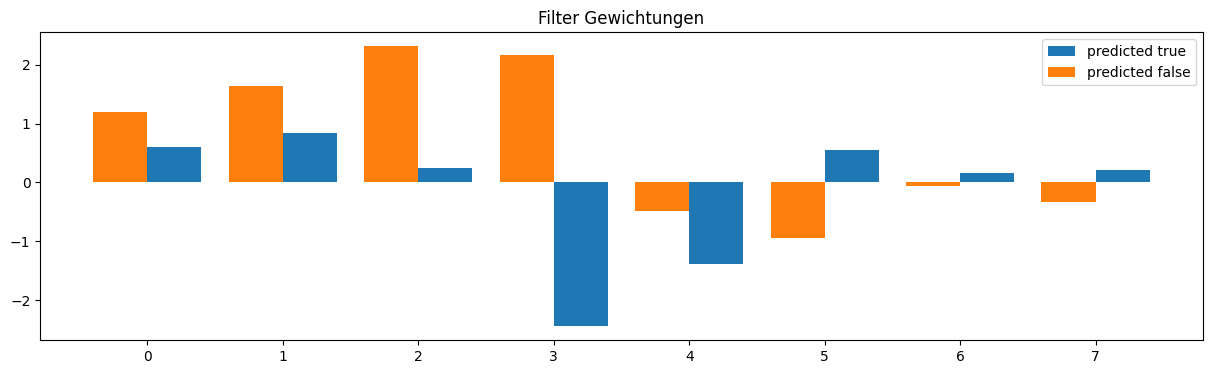

In [428]:
x_axis= np.array(range(0,len(sum_filter_for_true)))
fig,ax = plt.subplots(figsize=(15, 4))
plt.title("Filter Gewichtungen")
plt.bar(x_axis+0.2,sum_filter_for_true,0.4,label= "predicted true")
plt.bar(x_axis-0.2,sum_filter_for_false,0.4,label="predicted false")
plt.legend()
plt.show()

#### Nicht vortrainiertes Embedding

Model: "sequential_75"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_40 (Embedding)    (None, 40, 30)            586920    
                                                                 
 conv1d_93 (Conv1D)          (None, 33, 64)            15424     
                                                                 
 flatten_99 (Flatten)        (None, 2112)              0         
                                                                 
 dense_85 (Dense)            (None, 1)                 2113      
                                                                 
Total params: 604,457
Trainable params: 604,457
Non-trainable params: 0
_________________________________________________________________
None


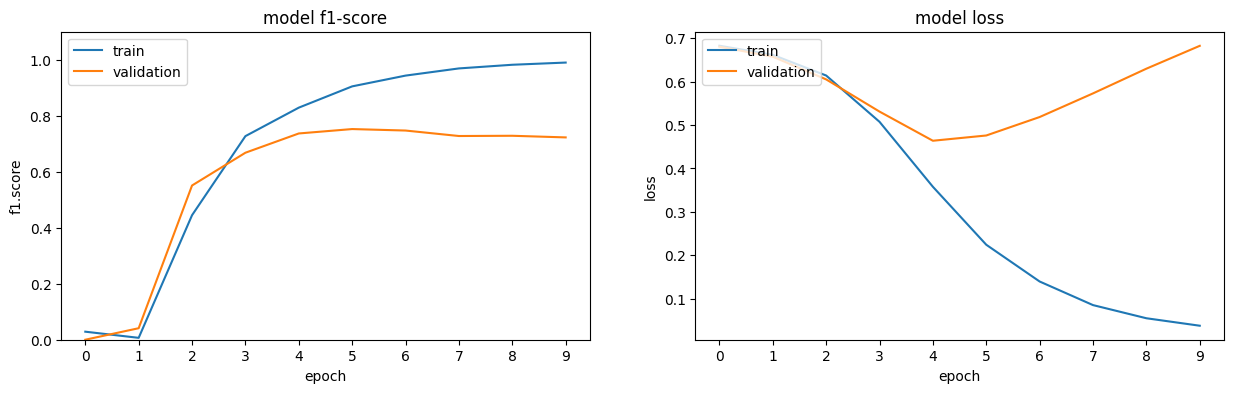

In [429]:
keras.utils.set_random_seed(812)
not_pretrained_emb = keras.layers.Embedding(vocab_size, 30, input_length=40)
history = conv_mlp(not_pretrained_emb,10)
plot_f1_score_loss(history)

In [430]:
%%capture
max_f1 = np.array(history.history["val_get_f1"]).argmax() +1
not_pretrained_cross5 = [conv_mlp(not_pretrained_emb,max_f1).history['val_get_f1'][-1] for n_runs in range(5)]

#### Word2vec Embeddings

Model: "sequential_81"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_34 (Embedding)    (None, 40, 300)           5869200   
                                                                 
 conv1d_99 (Conv1D)          (None, 33, 64)            153664    
                                                                 
 flatten_105 (Flatten)       (None, 2112)              0         
                                                                 
 dense_91 (Dense)            (None, 1)                 2113      
                                                                 
Total params: 6,024,977
Trainable params: 6,024,977
Non-trainable params: 0
_________________________________________________________________
None


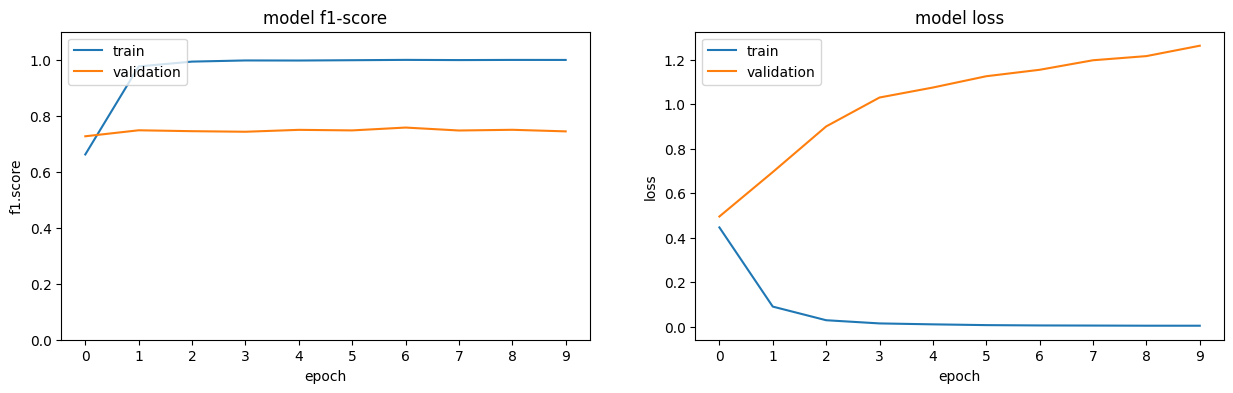

In [431]:
keras.utils.set_random_seed(812)
history = conv_mlp(embedding_word2vec,10)
plot_f1_score_loss(history)

In [432]:
%%capture
max_f1 = np.array(history.history["val_get_f1"]).argmax() +1
word2vec_cross5 = [conv_mlp(embedding_word2vec,max_f1).history['val_get_f1'][-1] for n_runs in range(5)]

#### Bert-tweet Embeddings

Model: "sequential_87"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_13 (Embedding)    (None, 40, 768)           15025152  
                                                                 
 conv1d_105 (Conv1D)         (None, 33, 64)            393280    
                                                                 
 flatten_111 (Flatten)       (None, 2112)              0         
                                                                 
 dense_97 (Dense)            (None, 1)                 2113      
                                                                 
Total params: 15,420,545
Trainable params: 15,420,545
Non-trainable params: 0
_________________________________________________________________


None


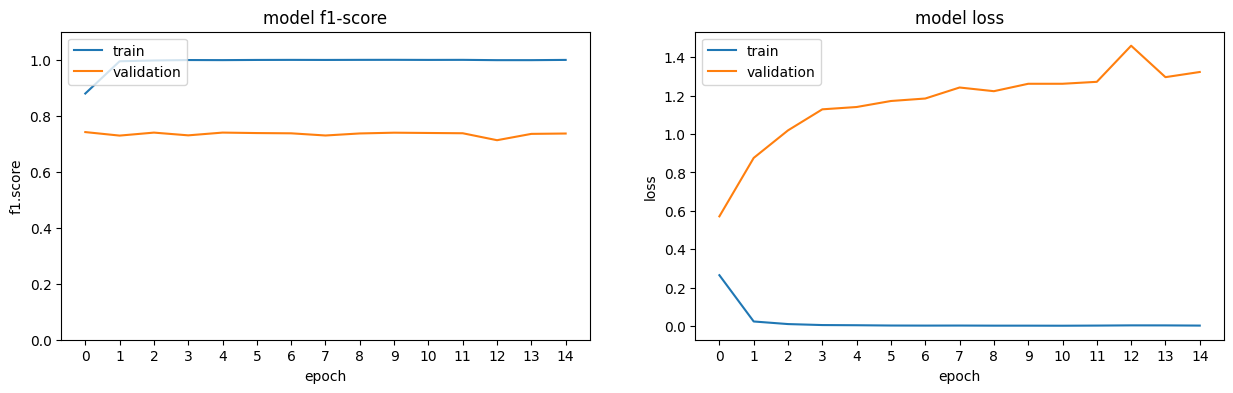

In [433]:
keras.utils.set_random_seed(812)
history = conv_mlp(embedding_bert,15)
plot_f1_score_loss(history)

In [ ]:
%%capture
max_f1 = np.array(history.history["val_get_f1"]).argmax() +1
bert_tweet_cross5 = [conv_mlp(embedding_bert,max_f1).history['val_get_f1'][-1] for n_runs in range(5)]

#### Vergleich

[Text(1, 0, 'not pretrained'),
 Text(2, 0, 'word2vec'),
 Text(3, 0, 'bert tweet')]

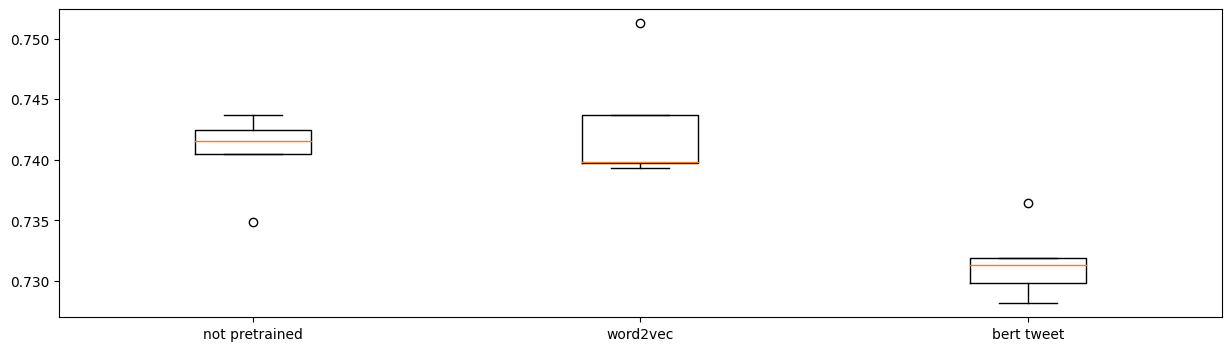

In [435]:
cross_validate = {"not pretrained": not_pretrained_cross5, "word2vec":word2vec_cross5, "bert tweet": bert_tweet_cross5}
fig,ax = plt.subplots(figsize=(15, 4))
ax.boxplot(cross_validate.values())
ax.set_xticklabels(cross_validate.keys())

### Zusätzliche Komplexität
Im nächsten Schritt wird untersucht, ob tiefere und komplexere Modelle bessere Resultate erzielen.
#### 3 convolutions, maxpooling, dropout, 2 mlp

In [238]:
def conv3_mlp2(n_epochs=20):
    model = keras.Sequential()
    model.add(embedding_word2vec)
    model.add(keras.layers.Conv1D(filters=128, kernel_size=5, activation='relu'))
    model.add(keras.layers.Dropout(0.25))
    model.add(keras.layers.MaxPooling1D(pool_size=2))
    model.add(keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(keras.layers.Dropout(0.25))
    model.add(keras.layers.MaxPooling1D(pool_size=2))
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dropout(0.25))
    model.add(keras.layers.Dense(100, activation="relu"))
    model.add(keras.layers.Dropout(0.25))
    model.add(keras.layers.Dense(20, activation="relu"))
    model.add(keras.layers.Dense(1, activation=tf.nn.sigmoid))
    print(model.summary())
    model.compile(optimizer=tf.optimizers.Adam() , loss='binary_crossentropy', metrics= get_f1)
    history = model.fit(train_tokens, train.target, epochs=n_epochs, batch_size=512, validation_data=(val_tokens, val.target), verbose=0)
    return history

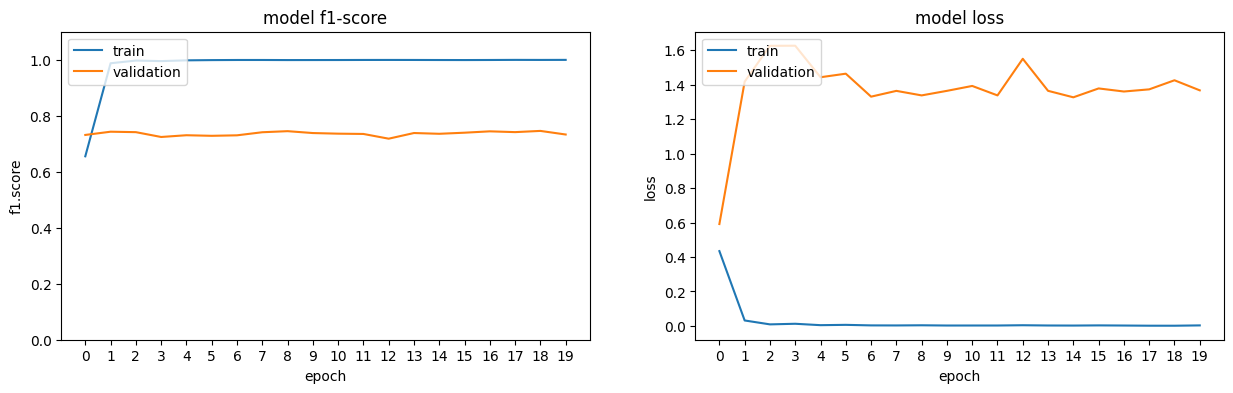

In [239]:
keras.utils.set_random_seed(812)
history = conv3_mlp2()
plot_f1_score_loss(history)

In [244]:
%%capture
max_f1 = np.array(history.history["val_get_f1"]).argmax() +1
word2vec_cross5_3conv_2mlp = [conv_mlp(embedding_word2vec,max_f1).history['val_get_f1'][-1] for n_runs in range(5)]

#### 3 Parallel convolutions

In [251]:
def create_convnet(sent_length, num_classes):
    input_shape =  keras.layers.Input(shape=(sent_length,))
    emb = embedding_word2vec(input_shape)

    tower_1 =  keras.layers.Conv1D(filters=256, kernel_size=5, activation='relu')(emb)
    #tower_1 =  keras.layers.GlobalMaxPooling1D()(tower_1)
    tower_1 = keras.layers.Flatten()(tower_1)

    tower_2 =  keras.layers.Conv1D(filters=128, kernel_size=4, activation='relu')(emb)
    #tower_2 =  keras.layers.GlobalMaxPooling1D()(tower_2)
    tower_2 = keras.layers.Flatten()(tower_2)

    tower_3 =  keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu')(emb)
    #tower_3 =  keras.layers.GlobalMaxPooling1D()(tower_3)
    tower_3 = keras.layers.Flatten()(tower_3)

    merged = keras.layers.concatenate([tower_1, tower_2, tower_3], axis=1)
    merged =  keras.layers.Flatten()(merged)

    out =  keras.layers.Dense(50, activation='relu')(merged)
    out =  keras.layers.Dense(num_classes, activation='sigmoid')(out)
    
    model = keras.Model(input_shape, out)
    print(model.summary())
    return model

def parallel3_conf(n_epochs=20):
    model = create_convnet(40,1)
    model.compile(optimizer=tf.optimizers.Adam() , loss='binary_crossentropy', metrics= get_f1)
    history = model.fit(train_tokens, train.target, epochs=n_epochs, batch_size=512, validation_data=(val_tokens, val.target), verbose=False)
    return history

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 40)]         0           []                               
                                                                                                  
 embedding_34 (Embedding)       (None, 40, 300)      5869200     ['input_3[0][0]']                
                                                                                                  
 conv1d_70 (Conv1D)             (None, 36, 256)      384256      ['embedding_34[2][0]']           
                                                                                                  
 conv1d_71 (Conv1D)             (None, 37, 128)      153728      ['embedding_34[2][0]']           
                                                                                            

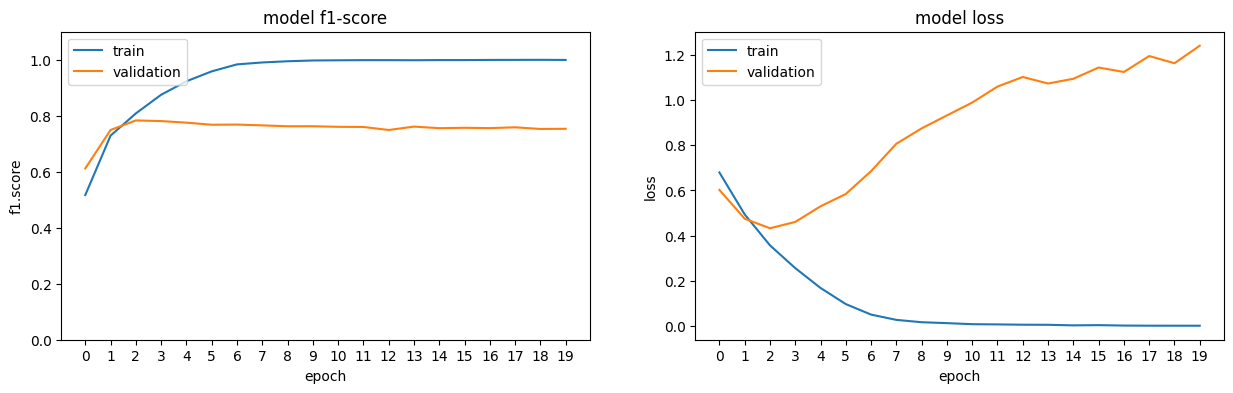

In [252]:
keras.utils.set_random_seed(812)
history = parallel3_conf()
plot_f1_score_loss(history)

In [253]:
%%capture
max_f1 = np.array(history.history["val_get_f1"]).argmax() +1
word2vec_cross5_parrallel3 = [parallel3_conf(max_f1).history['val_get_f1'][-1] for n_runs in range(5)]

#### Vergleich Modellkomplexität

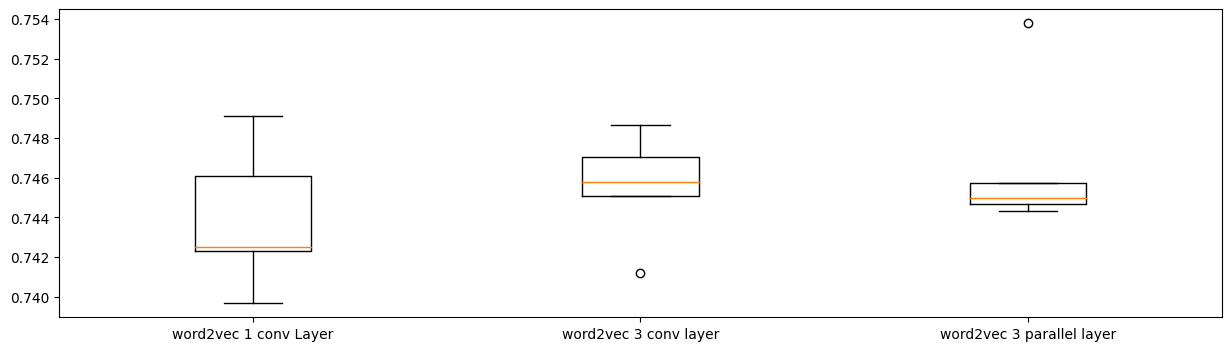

In [254]:
cross_validate = {"word2vec 1 conv Layer": word2vec_cross5, "word2vec 3 conv layer":word2vec_cross5_3conv_2mlp, "word2vec 3 parallel layer": word2vec_cross5_parrallel3}
fig,ax = plt.subplots(figsize=(15, 4))
ax.boxplot(cross_validate.values())
ax.set_xticklabels(cross_validate.keys())
plt.show()

### Auswertung des Modells

## Evaluation
In der Evaluation beschreiben wir, welche Metrik verwendet wurde, wieso die Metrik für den Anwendungsfall passt und diskutieren die Ergebnisse der Experimente und einige Vorhersagen auf einzelnen Testsamples.

## Erkenntnisse

## Fazit